# Classifying Pulsar Stars

##### Nandini Nandini, Runqi Zong, Shiori Hasegawa, YunYun Wei

## Introduction 

Pulsars are a type of neutron star that emits strong electromagnetic radiation that can be picked up through machines on Earth. According to an article by Haitao Lin and Xiangru Li,  the universe is scattered with many undiscovered pulsars and relies on machine learning to detect characteristic radio waves that can be further interpreted to uncover new pulsars (Lin, et al, 2020). However, due to the unique waves that each pulsar can produce and potential wave interference in space, it is challenging to identify real pulsars with high precision. To explore this problem, classification models will be imposed upon the HTRU-2 dataset to explore solutions for identifying ‘real pulsars’.  With information on standard deviation, mean, and skewness of categorical variables such as DM-SNR curve which stands for Dispersion Measure - Signal-to-Noise Ratio, that facilitates the process of identifying potential pulsars, integrated profiles which are summed up pulses detected from the pulsars, and kurtosis which is a statistical measure that separates pulsars to non-pulsars help come up with solutions building more accurate predictions models.

We will perform exploratory data analysis and visualization using the dataset “Pulsar Star Data” retrieved online from https://archive.ics.uci.edu/ml/datasets/HTRU2.


We will try to answer the question of how do numerical variables such as DM-SNR and integrated profiles help detect potential candidates that can be further classified as pulsars and non-pulsars?




In [ ]:
#Run this cell before continuing. 
install.packages("kknn")
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 6) #limits output of data frames to 6 rows

# Preliminary exploratory data analysis:


### Demonstrating that the dataset can be read from the web into R 

In [5]:
options(repr.matrix.max.rows = 6) #limits output of data frames to 6 rows

download.file("https://raw.githubusercontent.com/yunyun-wei/Group-project-proposal/main/HTRU_2.csv", "HTRU_2.csv")

pulsar_data <- read_delim("HTRU_2.csv", delim = ",",
  col_names= c("int_mean_profile",
               "int_sd_profile" ,
               "int_ex_kurtosis_profile",
               "int_skewness_profile",
               "dm_mean_curve",
               "dm_sd_curve",
               "dm_ex_kurtosis_curve",
               "dm_skewness_curve",
               "class"))
pulsar_data


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): int_mean_profile, int_sd_profile, int_ex_kurtosis_profile, int_skew...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


int_mean_profile int_sd_profile int_ex_kurtosis_profile
1     140.5625         55.68378       -0.2345714             
2     102.5078         58.88243        0.4653182             
3     103.0156         39.34165        0.3233284             
⋮     ⋮                ⋮              ⋮                      
17896 119.3359         59.93594       0.1593631              
17897 114.5078         53.90240       0.2011614              
17898  57.0625         85.79734       1.4063910              
      int_skewness_profile dm_mean_curve dm_sd_curve dm_ex_kurtosis_curve
1     -0.6996484           3.199833      19.11043     7.975532           
2     -0.5150879           1.677258      14.86015    10.576487           
3      1.0511644           3.121237      21.74467     7.735822           
⋮     ⋮                    ⋮             ⋮           ⋮                   
17896 -0.74302540           21.430602    58.87200     2.499517           
17897 -0.02478884            1.946488    13.38173    10.007967           
17898  0.08951971          188.306020    64.71256    -1.597527           
      dm_skewness_curve class
1      74.24222         0    
2     127.39358         0    
3      63.17191         0    
⋮     ⋮                 ⋮    
17896   4.595173        0    
17897 134.238910        0    
17898   1.429475        0

## Cleaning and Wrangling the data

Now, we will clean the data in a tidy format to meet our analysis needs.First changing the data type of the class variable then renaming the numeric data into "pulsar" if it is 1 and "non-pulsar" if it was 0.

In [6]:
pulsar_data <- pulsar_data |>
    mutate(class = as_factor(class)) |> 
    mutate(class = fct_recode(class, "Pulsar" = "1", "Non_pulsar" = "0")) 

pulsar_data



int_mean_profile int_sd_profile int_ex_kurtosis_profile
1     140.5625         55.68378       -0.2345714             
2     102.5078         58.88243        0.4653182             
3     103.0156         39.34165        0.3233284             
⋮     ⋮                ⋮              ⋮                      
17896 119.3359         59.93594       0.1593631              
17897 114.5078         53.90240       0.2011614              
17898  57.0625         85.79734       1.4063910              
      int_skewness_profile dm_mean_curve dm_sd_curve dm_ex_kurtosis_curve
1     -0.6996484           3.199833      19.11043     7.975532           
2     -0.5150879           1.677258      14.86015    10.576487           
3      1.0511644           3.121237      21.74467     7.735822           
⋮     ⋮                    ⋮             ⋮           ⋮                   
17896 -0.74302540           21.430602    58.87200     2.499517           
17897 -0.02478884            1.946488    13.38173    10.007967           
17898  0.08951971          188.306020    64.71256    -1.597527           
      dm_skewness_curve class     
1      74.24222         Non_pulsar
2     127.39358         Non_pulsar
3      63.17191         Non_pulsar
⋮     ⋮                 ⋮         
17896   4.595173        Non_pulsar
17897 134.238910        Non_pulsar
17898   1.429475        Non_pulsar

## Splitting in a training dataset
Now that our data is well-organized and in a tidy format, let's generate subsets and divide it into training and testing datasets.

Training Data: This subset is foundational for training predictive models to distinguish genuine from pulsar stars based on provided attributes. Analyzing this data helps uncover patterns for accurate predictions.

Testing Data: The testing data subset is vital for evaluating the reliability and performance of our predictive models. Once the system is trained on the training data, it's essential to assess its performance on unseen data to validate its generalization and accuracy.

In [21]:
set.seed(99) # for reproducibility

pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)

pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [8]:
set.seed(4)

select_pulsars <- filter(pulsar_data, class == "Pulsar") %>%
    slice_sample(n = 1000)

select_non_pulsars <- filter(pulsar_data, class == "Non_pulsar") %>%
    slice_sample(n = 1000)

sampled_pulsar_data <- bind_rows(select_pulsars, select_non_pulsars) 
sampled_pulsar_data 

int_mean_profile int_sd_profile int_ex_kurtosis_profile
1    97.64844         65.52750       0.6114969              
2    19.41406         36.90307       4.5746624              
3    70.41406         33.99116       2.5163443              
⋮    ⋮                ⋮              ⋮                      
1998 119.1875         49.99543       0.1491178              
1999 117.1094         54.16096       0.1300763              
2000 128.4609         50.52133       0.2028490              
     int_skewness_profile dm_mean_curve dm_sd_curve dm_ex_kurtosis_curve
1    -0.8051257           168.50251     89.03489    -0.8038317          
2    22.1739470            16.57776     40.84932     3.1399490          
3    10.9439999            23.41054     53.20626     2.5215806          
⋮    ⋮                    ⋮             ⋮           ⋮                   
1998 -0.3392781           3.440635      23.13829     7.800343           
1999 -0.5837763           1.501672      13.93172    11.536727           
2000 -0.4919704           2.832776      15.74431     7.571511           
     dm_skewness_curve class     
1    -0.8825193        Pulsar    
2    10.3558294        Pulsar    
3     5.8078190        Pulsar    
⋮    ⋮                 ⋮         
1998  65.29754         Non_pulsar
1999 154.87880         Non_pulsar
2000  76.89974         Non_pulsar

## Summarizing 
Now, we will summarize the training data based on our predictive class variable which will give a count of each observation of the class variable contained in the dataset. Another table would calculate the mean of each of the predictive variables which are int_mean_profile and dm_mean_curve. Luckily, Our data doesn't contain any missing values. 


In [9]:
pulsar_means <- select(pulsar_train, int_mean_profile, dm_mean_curve) |>
     			map_df(mean)
pulsar_means

pulsar_count <- pulsar_train |>
    group_by(class) |>
    summarize(count = n())
pulsar_count

total_rows <- nrow(pulsar_train)
total_rows

int_mean_profile dm_mean_curve
1 111.0245         12.73193

class      count
1 Non_pulsar 12164
2 Pulsar      1259

[1] 13423

Here, Out of 13423 training data rows, 12164 are Non-pulsor, and 1259 are Pulsor.

## Visualization
Now, we will plot the mean scatter plots for the exploratory variable.
It is visible from the plot that when the integrated profile is less along with increase in the Mean of the DM-SNR curve we get the class of pulsars.On the other hand when we have an increase in the integrated profile we can observe that the trends shifts to non-pulsars.

ERROR: Error in grid.arrange(mean_pulsar_plot, sd_pulsar_plot, ncol = 1): could not find function "grid.arrange"


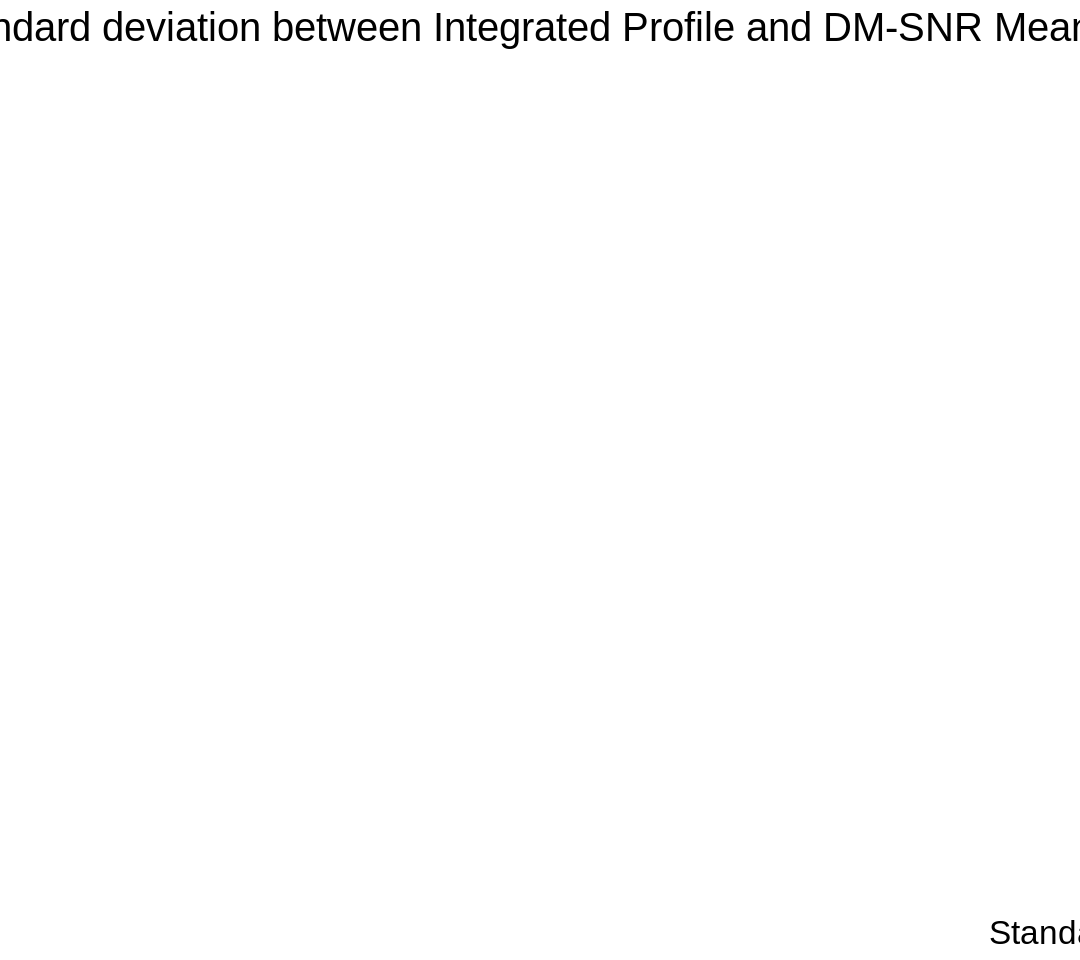

In [19]:
options(repr.plot.width = 9, repr.plot.height = 8)

# mean_pulsar_plot <-  ggplot(pulsar_train, aes(x = int_mean_profile,  y = dm_mean_curve, colour = class)) +
#                     geom_point(alpha = 0.5) +
#                     labs(x = "Integrated Mean Profile", y = "DM-SNR Mean Curve",
#                          tag= "Fig 1: Depicting the mean between Integrated Profile and DM-SNR Mean Curve",
#                     title = "Mean Integrated Profile v/s Mean DM-SNR Curve", colour = "Class") +
#                     theme(text= element_text(size = 20))
# mean_pulsar_plot



sd_pulsar_plot <-  ggplot(pulsar_train, aes(x = int_sd_profile,  y = dm_sd_curve, colour = class)) +
                    geom_point(alpha = 0.5) +
                    labs(x = "Standard Deviation of Integrated Profile", y = "Standard Deviation of DM-SNR Curve",
                          tag= "Fig 2: Depicting the standard deviation between Integrated Profile and DM-SNR Mean Curve",
                    title = "SD of Integrated Profile v/s SD of DM-SNR Curve", colour = "Class") +
                    theme(text= element_text(size = 20))
sd_pulsar_plot


grid.arrange(mean_pulsar_plot, sd_pulsar_plot, ncol= 1)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy binary     0.9567907 5 0.001194644 Preprocessor1_Model01
2  1         roc_auc  binary     0.8680169 5 0.006473158 Preprocessor1_Model01
3  2         accuracy binary     0.9567907 5 0.001194644 Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
28 14        roc_auc  binary     0.9465694 5 0.004026374 Preprocessor1_Model14
29 15        accuracy binary     0.9719887 5 0.001148756 Preprocessor1_Model15
30 15        roc_auc  binary     0.9466869 5 0.003790215 Preprocessor1_Model15

neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy binary     0.9567907 5 0.001194644 Preprocessor1_Model01
2  2         accuracy binary     0.9567907 5 0.001194644 Preprocessor1_Model02
3  3         accuracy binary     0.9687852 5 0.001047614 Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
13 13        accuracy binary     0.9715417 5 0.001179520 Preprocessor1_Model13
14 14        accuracy binary     0.9715417 5 0.001179520 Preprocessor1_Model14
15 15        accuracy binary     0.9719887 5 0.001148756 Preprocessor1_Model15

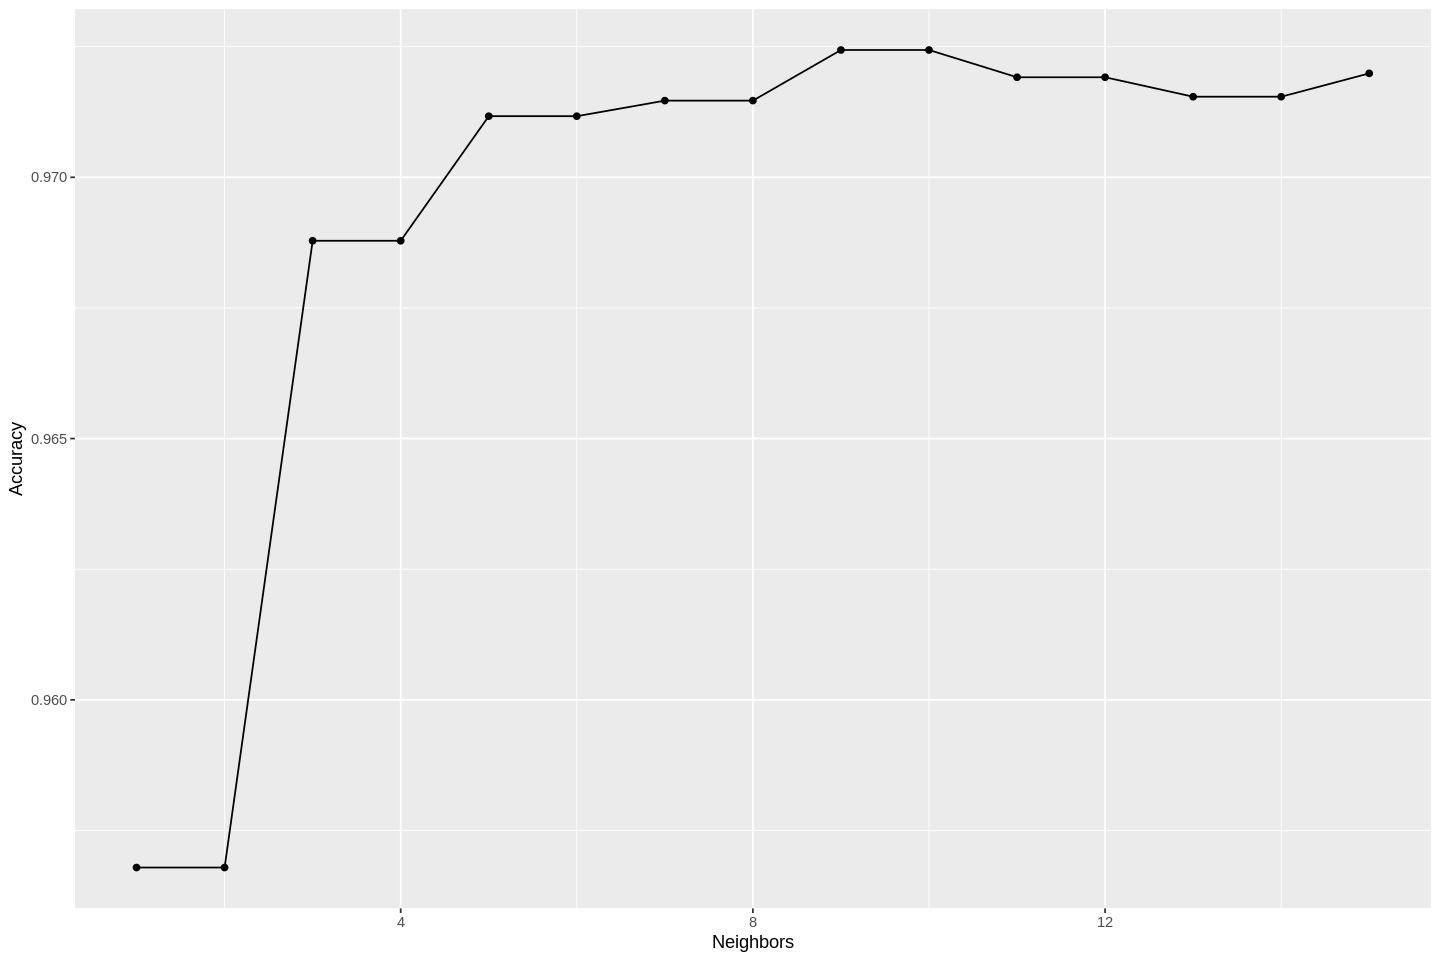

In [11]:
set.seed(2020)
pulsar_recipe<- recipe(class ~ dm_mean_curve + int_mean_profile, data= pulsar_train)|>
step_center(all_predictors())|>
step_scale(all_predictors())
pulsar_recipe

knn_spec<-nearest_neighbor(weight_func= "rectangular", neighbors= tune())|>
set_engine('kknn')|>
set_mode('classification')
knn_spec

pulsar_vfold<-vfold_cv(pulsar_train, v=5, strata= class)
#pulsar_vfold
# int_mean_profile_max<-arrange(pulsar_train, by=desc(int_mean_profile))|>
# slice(1)
# int_mean_profile_max
# int_mean_profile_min<-arrange(pulsar_train, int_mean_profile)|>
# slice(1)
# int_mean_profile_min

# dm_mean_curve_max<-arrange(pulsar_train, by=desc(dm_mean_curve))|>
# slice(1)
# dm_mean_curve_max

# dm_mean_curve_min<-arrange(pulsar_train, dm_mean_curve)|>
# slice(1)
# dm_mean_curve_min

#pulsar_grid<- tibble(neighbours= seq(from= 0, to=223, by=50))
                      
pulsar_results<-workflow() |>
add_recipe(pulsar_recipe) |>
add_model(knn_spec)|> 
tune_grid(resamples= pulsar_vfold, grid= 50) |>
collect_metrics()
pulsar_results

pulsar_accuracy<- filter(pulsar_results, .metric=="accuracy")
pulsar_accuracy


cross_val_plot<-ggplot(pulsar_accuracy, aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x= "Neighbors", y="Accuracy")
cross_val_plot




In [12]:
pulsar_best_k_model<-nearest_neighbor(weight_func= "rectangular", neighbors= 9)|>
set_engine('kknn')|>
set_mode('classification')
pulsar_best_k_model

pulsar_fit<- workflow()|>
add_recipe(pulsar_recipe)|>
add_model(pulsar_best_k_model)|>
fit(data= pulsar_train)
pulsar_fit

pulsar_predictions<- predict(pulsar_fit, pulsar_test)|>
bind_cols(pulsar_test)
pulsar_predictions

pulsar_metrics<- pulsar_predictions|>
metrics(truth= class, estimate= .pred_class)
pulsar_metrics

pulsar_conf_mat<-pulsar_predictions|>
conf_mat(truth= class, estimate= .pred_class)
pulsar_conf_mat

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 9
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02786262
Best kernel: rectangular
Best k: 9

.pred_class int_mean_profile int_sd_profile int_ex_kurtosis_profile
1    Non_pulsar  140.5625         55.68378       -0.23457141            
2    Non_pulsar  136.7500         57.17845       -0.06841464            
3    Non_pulsar  136.0938         51.69100       -0.04590893            
⋮    ⋮           ⋮                ⋮              ⋮                      
4473 Non_pulsar  121.3750         53.24516       0.1037722              
4474 Non_pulsar  119.3359         59.93594       0.1593631              
4475 Non_pulsar  114.5078         53.90240       0.2011614              
     int_skewness_profile dm_mean_curve dm_sd_curve dm_ex_kurtosis_curve
1    -0.6996484           3.199833      19.11043    7.975532            
2    -0.6362384           3.642977      20.95928    6.896499            
3    -0.2718164           9.342809      38.09640    4.345438            
⋮    ⋮                    ⋮             ⋮           ⋮                   
4473 -0.36511875           1.095318     12.23998    16.258042           
4474 -0.74302540          21.430602     58.87200     2.499517           
4475 -0.02478884           1.946488     13.38173    10.007967           
     dm_skewness_curve class     
1    74.24222          Non_pulsar
2    53.59366          Non_pulsar
3    18.67365          Non_pulsar
⋮    ⋮                 ⋮         
4473 303.880023        Non_pulsar
4474   4.595173        Non_pulsar
4475 134.238910        Non_pulsar

.metric  .estimator .estimate
1 accuracy binary     0.9729609
2 kap      binary     0.8175202

            Truth
Prediction   Non_pulsar Pulsar
  Non_pulsar       4054     80
  Pulsar             41    300

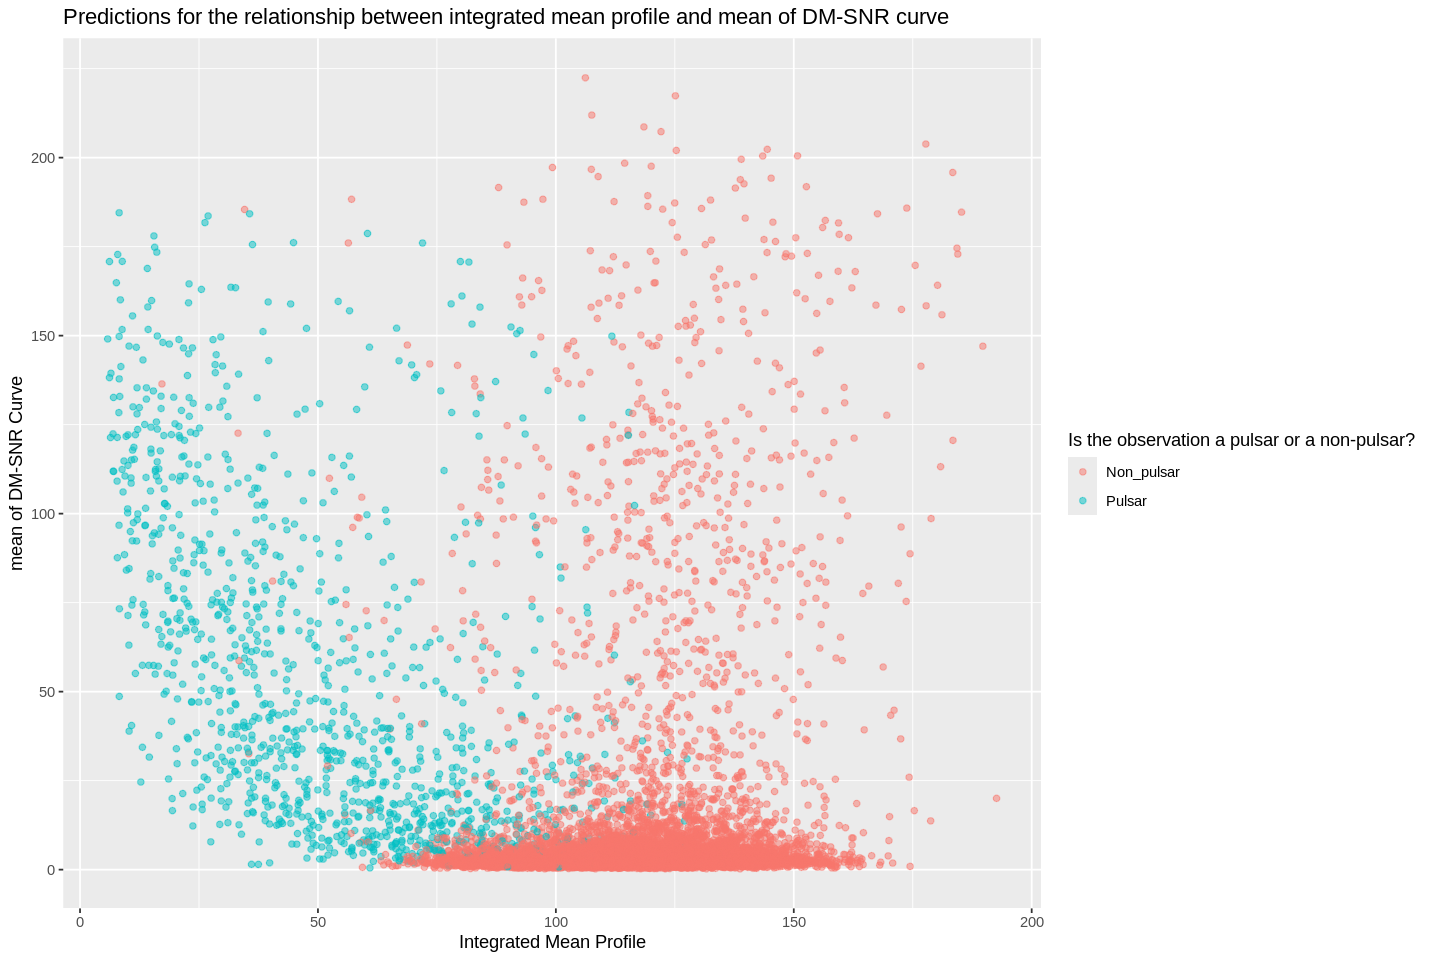

In [13]:
pulsar_predictions_plot<- ggplot(mapping= aes(x=int_mean_profile, y=dm_mean_curve, color= class))+
geom_point(data=pulsar_train, alpha=0.5)+
labs(color= "Is the observation a pulsar or a non-pulsar?", x= "Integrated Mean Profile", y= "mean of DM-SNR Curve")+
ggtitle("Predictions for the relationship between integrated mean profile and mean of DM-SNR curve")
pulsar_predictions_plot

# Methods

- In order to make further predictions, columns, “int_mean_profile” and “dm_mean_curve” will be used as explanatory variables to plot a scatter plot where the x-axis reflects data on the integrated profile and the y-axis reflects data on the DM-SNR curve. The data points are coloured based on the categorization of a pulsar or non_pulsar.
- Scatterplots can also be put in place to identify the strength of the relationship between the predictors. This gives more context for picking variables that can maximize the precision and accuracy of identifying real pulsars in future observations.
- A knn model will be built using scatter plot graphs to help predict new observations that could be potential candidates for pulsars. This requires using 5-fold validation models to determine the best K used to maximize prediction accuracies.



## Expected outcomes and significance
What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

- We expect to find distinct trends and relationships displayed in the scatterplot that could help make distinct observations and separation between pulsar data points and non-pulsar data points.
- Such findings could help build a knn model to help classify and predict further potential pulsar candidates as either a pulsar or non-pulsar.
- Building an accurate model can help scientists efficiently detect pulsars that were under the radar and expand our knowledge about space.



## Future Questions
- Despite using the model,  accuracy and precision might not be ensured through binary classification. This opens up to further questions on whether there are other methods that can give more accurate results and predictions.
- In a scientific perspective, how does building accurate prediction models of pulsars contribute to our understanding of space time?
- Can such data on pulsars offer more insight to building more useful human technologies that aim to explore more territory in space? In what way?
- Is there a correlation between the mean integrated profile and the Excess kurtosis of the DM-SNR curve of pulsar candidates?



# References
Lin, Haitao, et al. “Pulsars Detection by Machine Learning with Very Few Features.” Monthly Notices of the Royal Astronomical Society, vol. 493, no. 2, 28 Jan. 2020, pp. 1842–1854, https://doi.org/10.1093/mnras/staa218. Accessed 28 Apr. 2021.
Lyon, Robert. “UCI Machine Learning Repository.” Archive.ics.uci.edu, 1987, archive.ics.uci.edu/dataset/372/htru2.

## Data Citation
 Robert Lyon (2017), https://archive.ics.uci.edu/dataset/372/htru2, UC Irvine Machine Learning Repository